In [3]:
!pip install fsspec


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
df = pd.read_csv(r"C://Users//etale//Documents//week10//BrentOilPrices.csv")

In [5]:
# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Resample to monthly frequency, taking the average price
monthly_df = df['Price'].resample('M').mean().to_frame()

# Show preview
monthly_df.head()

C:\Users\etale\AppData\Local\Temp\ipykernel_9940\2423942362.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\etale\AppData\Local\Temp\ipykernel_9940\2423942362.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df['Price'].resample('M').mean().to_frame()


,Price
Date,
1987-05-31,18.580000
1987-06-30,18.860476
1987-07-31,19.856522
1987-08-31,18.979524
1987-09-30,18.313182


In [14]:
# Focus on closing prices
prices = df['Price'].values
n_days = len(prices)

In [15]:
with pm.Model() as model:
    # Prior for the unknown change point (τ)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n_days - 1)

    # Priors for means before and after the change
    mu_1 = pm.Normal('mu_1', mu=np.mean(prices), sigma=np.std(prices))
    mu_2 = pm.Normal('mu_2', mu=np.mean(prices), sigma=np.std(prices))

    # Priors for standard deviations
    sigma_1 = pm.HalfNormal('sigma_1', sigma=10)
    sigma_2 = pm.HalfNormal('sigma_2', sigma=10)

    # Define the mean and sigma based on switch point τ
    idx = np.arange(n_days)
    mu = pm.math.switch(tau >= idx, mu_1, mu_2)
    sigma = pm.math.switch(tau >= idx, sigma_1, sigma_2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=prices)

    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma_1, sigma_2]


C:\Users\etale\AppData\Local\Programs\Python\Python313\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ValueError: Not enough samples to build a trace.

In [13]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Assume `log_returns` is your prepared NumPy array of log return values
# You can extract it from your DataFrame like this:
# log_returns = df['log_return'].dropna().values

# Step 1: Prepare data
log_returns = df['log_return'].dropna().values
n = len(log_returns)
x = np.arange(n)

# Step 2: Build the model
with pm.Model() as model:
    # Define a discrete uniform prior for the change point location (tau)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n)

    # Priors for mean and std before and after the change point
    mu_1 = pm.Normal("mu_1", mu=log_returns.mean(), sigma=1)
    mu_2 = pm.Normal("mu_2", mu=log_returns.mean(), sigma=1)

    sigma_1 = pm.HalfNormal("sigma_1", sigma=1)
    sigma_2 = pm.HalfNormal("sigma_2", sigma=1)

    # Create mean and std arrays based on the switch point
    mu = pm.math.switch(x < tau, mu_1, mu_2)
    sigma = pm.math.switch(x < tau, sigma_1, sigma_2)

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=log_returns)

    # Step 3: Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True, random_seed=42)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma_1, sigma_2]


C:\Users\etale\AppData\Local\Programs\Python\Python313\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ValueError: Not enough samples to build a trace.

In [ ]:
# Step 4: Trace summary
az.summary(trace, var_names=["tau", "mu_1", "mu_2", "sigma_1", "sigma_2"])

In [ ]:
# Step 5: Trace plot
az.plot_trace(trace, var_names=["tau", "mu_1", "mu_2"])
plt.show()

In [ ]:
# Step 6: Posterior of change point
plt.figure(figsize=(10, 4))
plt.title("Posterior Distribution of Change Point (tau)")
az.plot_posterior(trace, var_names=["tau"])
plt.axvline(trace.posterior["tau"].mean(), color="red", linestyle="--", label="Mean tau")
plt.legend()
plt.show()


In [ ]:
# Get the most probable change point
tau_map = int(trace.posterior['tau'].mean().values)
# Plot log return series with the change point
plt.figure(figsize=(12, 4))
plt.plot(df.index[1:], log_returns, label="Log Returns", color="gray")
plt.axvline(df.index[tau_map + 1], color="red", linestyle="--", label="Change Point")
plt.title("Log Returns with Detected Change Point")
plt.legend()
plt.show()


Matplotlib is building the font cache; this may take a moment.


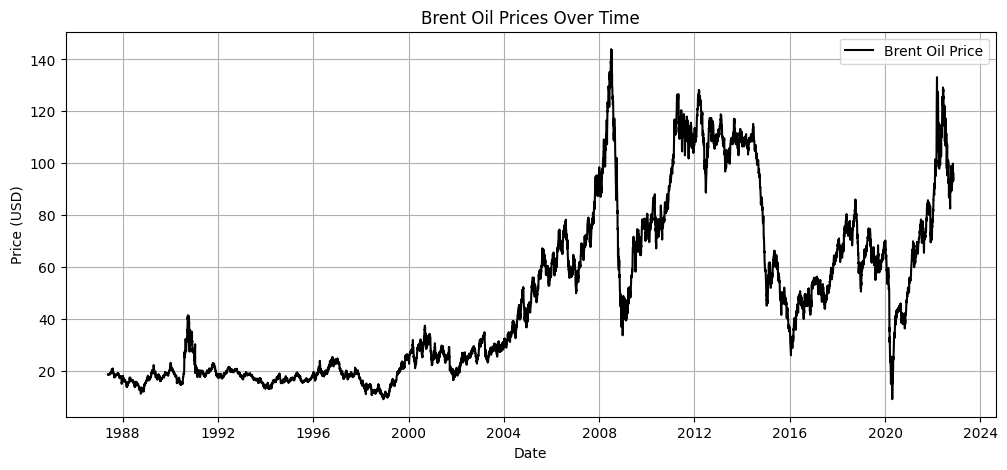

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(df['Price'], label='Brent Oil Price', color='black')
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()


In [9]:
import numpy as np
# Calculate log returns
df['log_return'] = np.log(df['Price'] / df['Price'].shift(1))
df.dropna(inplace=True)  # Drop the first row with NaN log return
df.head()


,Price,log_return
Date,,
1987-05-21,18.45,-0.009709
1987-05-22,18.55,0.005405
1987-05-25,18.60,0.002692
1987-05-26,18.63,0.001612
1987-05-27,18.60,-0.001612


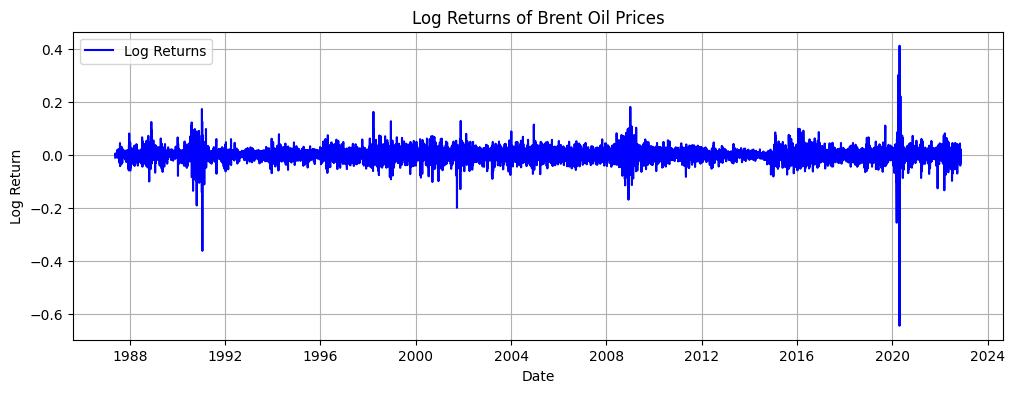

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(df['log_return'], label='Log Returns', color='blue')
plt.title("Log Returns of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.legend()
plt.show()